In [1]:
# 1.1 导入库
import os
import re
import pydicom
import cv2
import random
import imageio
import scipy.ndimage
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import MaxPool3D
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

label_dir = 'D:\\DBT\\BCS-DBT labels-train-v2.csv'
main_dir = 'D:\\DBT\\manifest-1691398083946\\'
data_dir = main_dir + 'Breast-Cancer-Screening-DBT\\'
labels_df = pd.read_csv(label_dir)
print("准备成功!")

准备成功!


In [3]:
def random_3d_rotation(volume):
    angle = np.random.uniform(-10, 10)
    rotated_volume = scipy.ndimage.rotate(volume, angle, axes=(1, 2), mode='nearest')
    diff_slices = volume.shape[0] - rotated_volume.shape[0]
    diff_height = volume.shape[1] - rotated_volume.shape[1]
    diff_width = volume.shape[2] - rotated_volume.shape[2]
    padding = (
        (max(diff_slices // 2, 0), max((diff_slices + 1) // 2, 0)),
        (max(diff_height // 2, 0), max((diff_height + 1) // 2, 0)),
        (max(diff_width // 2, 0), max((diff_width + 1) // 2, 0))
    )
    cropping = (
        slice(-min(diff_slices // 2, 0), rotated_volume.shape[0] + min((diff_slices + 1) // 2, 0)),
        slice(-min(diff_height // 2, 0), rotated_volume.shape[1] + min((diff_height + 1) // 2, 0)),
        slice(-min(diff_width // 2, 0), rotated_volume.shape[2] + min((diff_width + 1) // 2, 0))
    )
    rotated_volume = np.pad(rotated_volume[cropping], padding, mode='constant')
    return rotated_volume

def random_3d_flip(volume):
    axis = np.random.choice([0, 1, 2])
    return np.flip(volume, axis=axis)

def read_and_create_dataset(data_dir, labels_df, num_slices=10):
    labels_df_unique = labels_df.drop_duplicates(subset='PatientID', keep='first')
    X = []
    y = []
    for folder0_dir in sorted(os.listdir(data_dir)):
        patient_id = folder0_dir
        if not folder0_dir.startswith('DBT'):
            continue
        if patient_id not in labels_df_unique['PatientID'].values:
            continue
        label = labels_df_unique.loc[labels_df_unique['PatientID'] == patient_id, ['Normal', 'Actionable', 'Benign', 'Cancer']].values[0]
        folder0_dir = os.path.join(data_dir, folder0_dir)
        for folder1_dir in sorted(os.listdir(folder0_dir)):
            folder1_dir = os.path.join(folder0_dir, folder1_dir)
            for folder2_dir in sorted(os.listdir(folder1_dir)):
                case_id = patient_id + '_' + folder2_dir
                folder2_dir = os.path.join(folder1_dir, folder2_dir)
                png_paths = [os.path.join(folder2_dir, path) for path in os.listdir(folder2_dir) if path.endswith('.png')]
                png_paths_sorted = sorted(png_paths, key=natural_sort_key)
                step = len(png_paths_sorted) // num_slices
                if step == 0:
                    raise ValueError("num_slices is greater than the number of available PNG files. Please reduce num_slices or check the directory.")
                png_paths_uniform = [png_paths_sorted[i] for i in range(0, len(png_paths_sorted), step)][:num_slices]
                img_list = []
                print(f'处理{case_id}中')
                for png_path in png_paths_uniform:
                    img = Image.open(png_path)
                    new_size = (80,100)
                    img = img.convert('L')
                    img = img.resize(new_size, Image.LANCZOS)
                    img_array = np.array(img)
                    img_array = standardize_image(img_array)
                    img_list.append(img_array)
                img_array = np.stack(img_list, axis=0) 
                X.append(img_array)
                y.append(label)
                augmentations = 1
                for _ in range(augmentations):
                    augmented_img_array = img_array.copy()
                    if np.random.rand() > 0.5:
                        augmented_img_array = random_3d_rotation(augmented_img_array)
                    if np.random.rand() > 0.5:
                        augmented_img_array = random_3d_flip(augmented_img_array)
                    
                    X.append(augmented_img_array)
                    y.append(label)
    X = np.array(X)
    X = np.expand_dims(X, axis=-1)
    y = np.array(y)
    return X, y

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split('(\d+)', s)]
def standardize_image(image):
    standardized_image = image / np.max(image)
    return standardized_image


X, y = read_and_create_dataset(data_dir, labels_df,20)

处理DBT-P00013_20566.000000-NA-32081中
处理DBT-P00023_19710.000000-NA-51654中
处理DBT-P00023_19711.000000-NA-14072中
处理DBT-P00023_19712.000000-NA-09387中
处理DBT-P00023_19713.000000-NA-61579中
处理DBT-P00024_14782.000000-NA-91029中
处理DBT-P00024_14783.000000-NA-53289中
处理DBT-P00029_229.000000-NA-39407中
处理DBT-P00029_230.000000-NA-30080中
处理DBT-P00029_231.000000-NA-99185中
处理DBT-P00029_232.000000-NA-42826中
处理DBT-P00032_9670.000000-NA-95147中
处理DBT-P00032_9671.000000-NA-81650中
处理DBT-P00032_9672.000000-NA-52664中
处理DBT-P00032_9673.000000-NA-01012中
处理DBT-P00045_2665.000000-NA-56730中
处理DBT-P00045_2666.000000-NA-26372中
处理DBT-P00045_2667.000000-NA-29110中
处理DBT-P00045_2668.000000-NA-80894中
处理DBT-P00052_2861.000000-NA-84115中
处理DBT-P00052_2862.000000-NA-19991中
处理DBT-P00052_2863.000000-NA-05408中
处理DBT-P00052_2864.000000-NA-10096中
处理DBT-P00060_10132.000000-NA-67888中
处理DBT-P00064_20252.000000-NA-27294中
处理DBT-P00064_20253.000000-NA-31042中
处理DBT-P00064_20254.000000-NA-55116中
处理DBT-P00064_20255.000000-NA-52213中
处理DBT-P00064

处理DBT-P01347_3992.000000-NA-13434中
处理DBT-P01439_5189.000000-NA-33192中
处理DBT-P01461_20284.000000-NA-24547中
处理DBT-P01461_20285.000000-NA-73584中
处理DBT-P01488_9196.000000-NA-13599中
处理DBT-P01488_9197.000000-NA-04594中
处理DBT-P01493_3537.000000-NA-41887中
处理DBT-P01493_3538.000000-NA-07093中
处理DBT-P01539_14136.000000-NA-76114中
处理DBT-P01539_14137.000000-NA-96589中
处理DBT-P01587_13051.000000-NA-06426中
处理DBT-P01587_13052.000000-NA-97181中
处理DBT-P01624_5179.000000-NA-07086中
处理DBT-P01624_5180.000000-NA-11459中
处理DBT-P01626_1029.000000-NA-41286中
处理DBT-P01626_1030.000000-NA-12792中
处理DBT-P01673_12558.000000-NA-63058中
处理DBT-P01673_12559.000000-NA-24133中
处理DBT-P01712_9194.000000-NA-43456中
处理DBT-P01712_9195.000000-NA-84984中
处理DBT-P01718_6813.000000-NA-32583中
处理DBT-P01718_6814.000000-NA-90142中
处理DBT-P01745_15690.000000-NA-44302中
处理DBT-P01745_15691.000000-NA-81114中
处理DBT-P01751_16074.000000-NA-65721中
处理DBT-P01753_8978.000000-NA-75393中
处理DBT-P01753_8979.000000-NA-56601中
处理DBT-P01801_839.000000-NA-76312中
处理DBT-P018

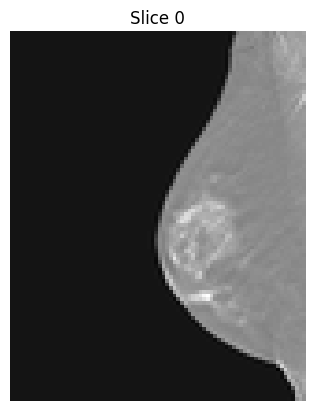

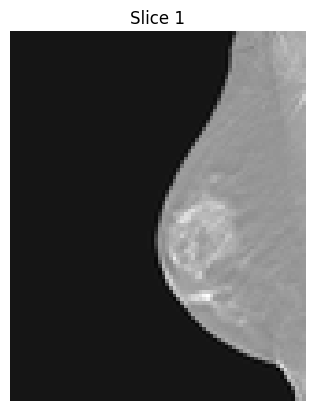

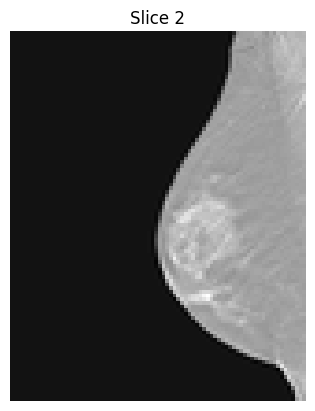

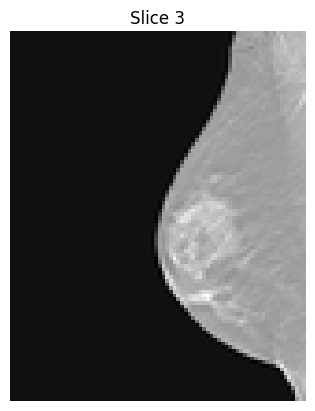

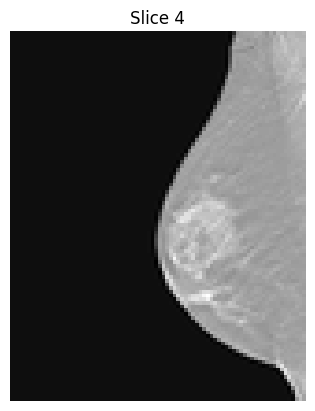

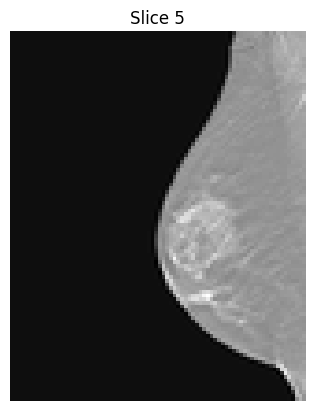

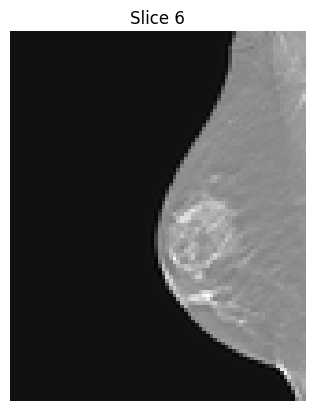

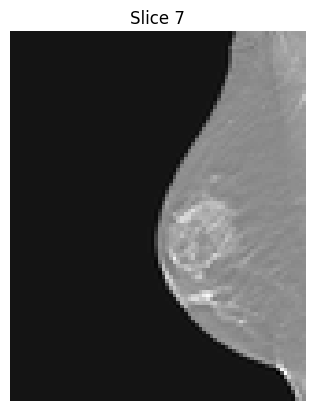

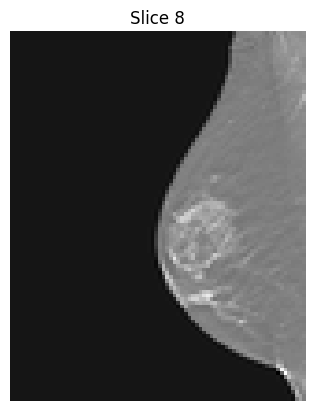

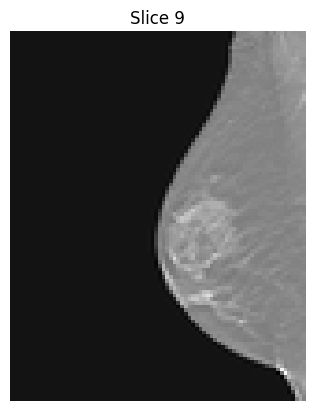

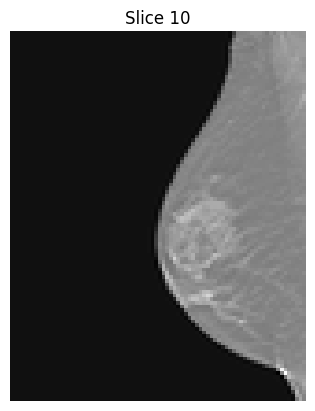

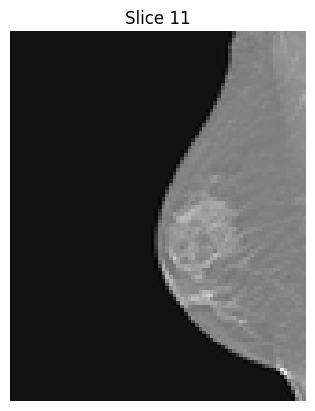

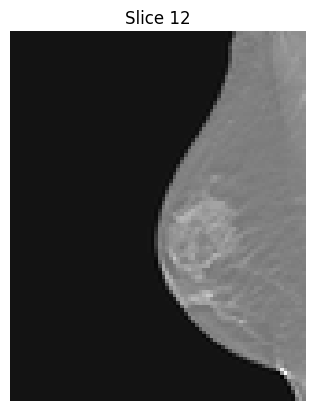

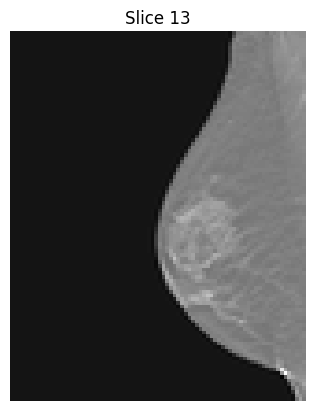

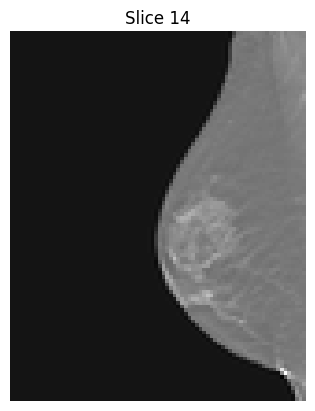

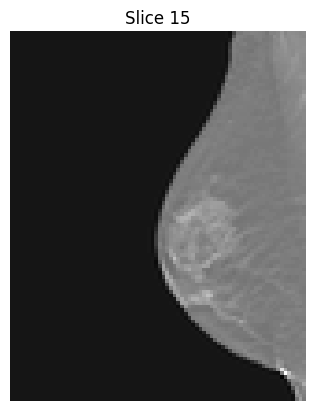

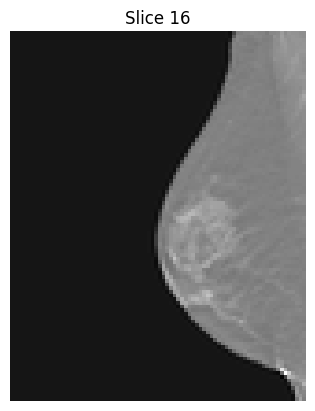

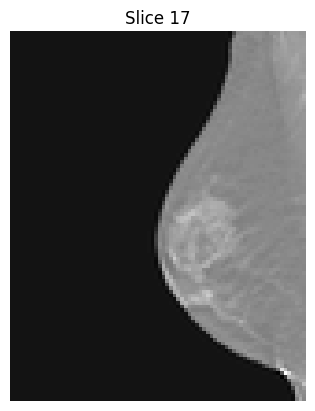

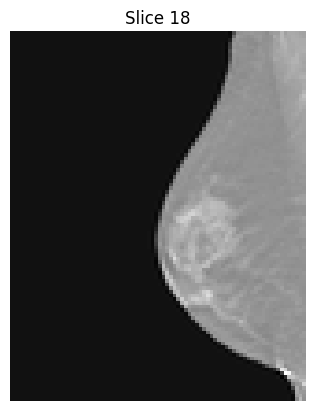

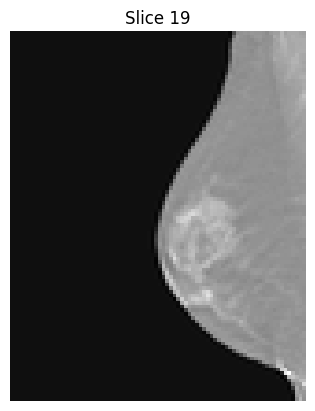

In [4]:
import matplotlib.pyplot as plt
sample_index = 0
sample_image_3d = X[sample_index]
num_slices = sample_image_3d.shape[0]
for i in range(num_slices):
    slice_image = sample_image_3d[i, :, :, 0] 
    plt.imshow(slice_image, cmap='gray') 
    plt.title(f'Slice {i}')
    plt.axis('off') 
    plt.show()

In [5]:
np.save('X1.npy', X)
np.save('y1.npy', y)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_train.dtype)
print(y_train.dtype)

print('划分完成！')

(674, 20, 100, 80, 1)
(674, 4)
(539, 20, 100, 80, 1)
(539, 4)
float64
int64
划分完成！
